## This notebook provides code to compute t-sne 2-dimensional features after applying PCA (to reach 50 dim) on MAE features. Computation is made on two different dataset : weather image recognition dataset and subset of Places365 dataset. We also provide code to make the same experiment with SimCLR model.

In [20]:
import pandas as pd
import seaborn as sns
import numpy as np
import torch.nn.functional as F
from tqdm import tqdm
import os
from utils.projector_utils import DATA_2, images_to_sprite,extractor,path_labels_extractor
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torch
import torchvision.datasets as datasets
from torchvision import transforms
from matplotlib import pyplot as plt
from utils.load_models import load_mae,load_simclr
inet_mean = [0.485, 0.456, 0.406]
inet_std = [0.229, 0.224, 0.225]
current = os.getcwd()


## Extract datasets and load model

In [2]:
WEATHER_PATH = current + '\\dataset' #folder to store images
PLACES_PATH = current + '\\places_4'
if not os.path.exists(WEATHER_PATH):
    from zipfile import ZipFile
    with ZipFile("archive.zip", 'r') as zObject: #the weather image recognition dataset provide this "archive.zip" file when it's downloaded from kaggle.
        zObject.extractall()

if not os.path.exists(PLACES_PATH):
    from zipfile import ZipFile
    with ZipFile("places_4.zip", 'r') as zObject: #the weather image recognition dataset provide this "archive.zip" file when it's downloaded from kaggle.
        zObject.extractall()
        
#Loading the model
import torch
device = 'cuda' if torch.cuda.is_available() else('cpu')
print(device)
#Loading VitMAE model pretrained on imagenet 64*64
model = load_mae().to(device)

cuda
Model loaded.


## Extract list of image paths and labels for each dataset. Also compute a class dictionnary for plot and number of wrong-shape images

In [5]:
weather_list,weather_labels,weather_classes,weather_bads = path_labels_extractor(WEATHER_PATH)
places_list,places_labels,places_classes,places_bads = path_labels_extractor(PLACES_PATH)


100%|██████████| 4/4 [00:19<00:00,  4.85s/it]


## Define usefull functions : load dataset features, transform them with PCA and TSNE, plot the result

In [6]:


def plot(x,labels,class_dict=None):
  df = pd.DataFrame(x,columns=['premier axe',"deuxieme axe"])

  df['y'] = [str(labels[i]) for i in range(len(labels))] if class_dict==None else [class_dict[str(labels[i])] for i in range(len(labels))]
  plt.figure(figsize=(16,10))
  sns.scatterplot(
    x="premier axe", y="deuxieme axe",
    hue="y",
    palette=sns.color_palette("hls", len(np.unique(labels))),
    data=df,
    legend="full",
    alpha=0.3
  )
    

def knn(f,labels,k=20):
  success = 0

  for id in tqdm(range(len(f))):
    f0 = f[id]
    similarities = F.cosine_similarity(f0,f)

    neighbors_classes = torch.tensor([labels[i] for i in torch.argsort(similarities,descending=True)[1:k+1]])
    candidates,counts = torch.unique(neighbors_classes,return_counts=True)
    predicted_class = candidates[torch.argmax(counts)].item()

    if labels[id]==predicted_class:
      success+=1
  return(success/len(f))

def project(e,model_type='vitmae',return_pca=False):

  X_embeddings = embed(e,model_type)
  print('Computing PCA and TSNE')
  pca = PCA(n_components=50,random_state = 0)
  X_pca = pca.fit_transform(X_embeddings)
  if return_pca:
    return(X_pca)
  tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000)
  X_tsne = tsne.fit_transform(X_pca)
  return(X_tsne)

def embed(e,model_type='vitmae'):
  print('Computing embeddings.')
  X_embeddings = []
  for x in tqdm(range(e.dataset.__len__())): 
      if model_type=='vitmae':
        img_embedding = e.get_embed(x,mask_ratio=0)
      elif model_type=='simclr':
        img_embedding = e.get_embed_simclr(x)

      #img_embedding = get_embed_simclr(x )
      X_embeddings.append(img_embedding.cpu().detach().numpy())
  return(X_embeddings)

## Start computation 

In [ ]:
places = DATA_2(places_list,places_labels, transform = None, mean = inet_mean,std = inet_std,img_size = 64,max_label=15)
weather = DATA_2(weather_list,weather_labels, transform = None, mean = inet_mean,std = inet_std,img_size = 64,max_label=15)

In [7]:
e_places = extractor(model,places,device)
places_y = project(e_places)


Computing embeddings.


100%|██████████| 20000/20000 [02:50<00:00, 117.07it/s]


Computing PCA and TSNE


C:\Users\ilias\anaconda3\envs\tpenv\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\ilias\anaconda3\envs\tpenv\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 20000 samples in 0.003s...
[t-SNE] Computed neighbors for 20000 samples in 0.543s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed conditional probabilities for sample 12000 / 20000
[t-SNE] Computed conditional probabilities for sa

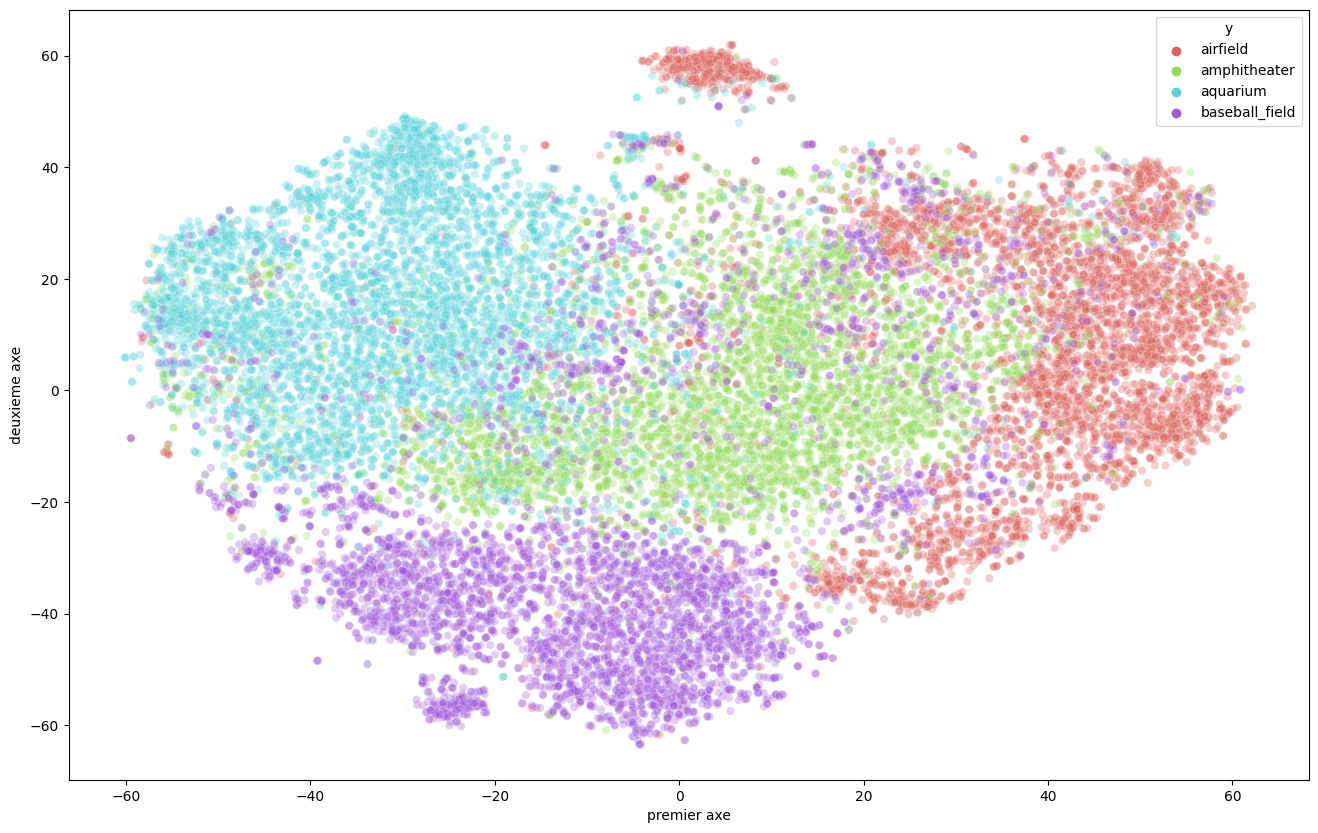

In [31]:
plot(places_y,e.dataset.labels_list,places_classes)

In [8]:
model_simclr = load_simclr().to(device)
e_places_simclr = extractor(model_simclr,places,device)
places_y_simclr = project(e_places_simclr,model_type='simclr')

C:\Users\ilias\anaconda3\envs\tpenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\ilias\anaconda3\envs\tpenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model loaded.
Computing embeddings.


100%|██████████| 20000/20000 [02:26<00:00, 136.85it/s]


Computing PCA and TSNE


C:\Users\ilias\anaconda3\envs\tpenv\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\ilias\anaconda3\envs\tpenv\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 20000 samples in 0.002s...
[t-SNE] Computed neighbors for 20000 samples in 0.469s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed conditional probabilities for sample 12000 / 20000
[t-SNE] Computed conditional probabilities for sa

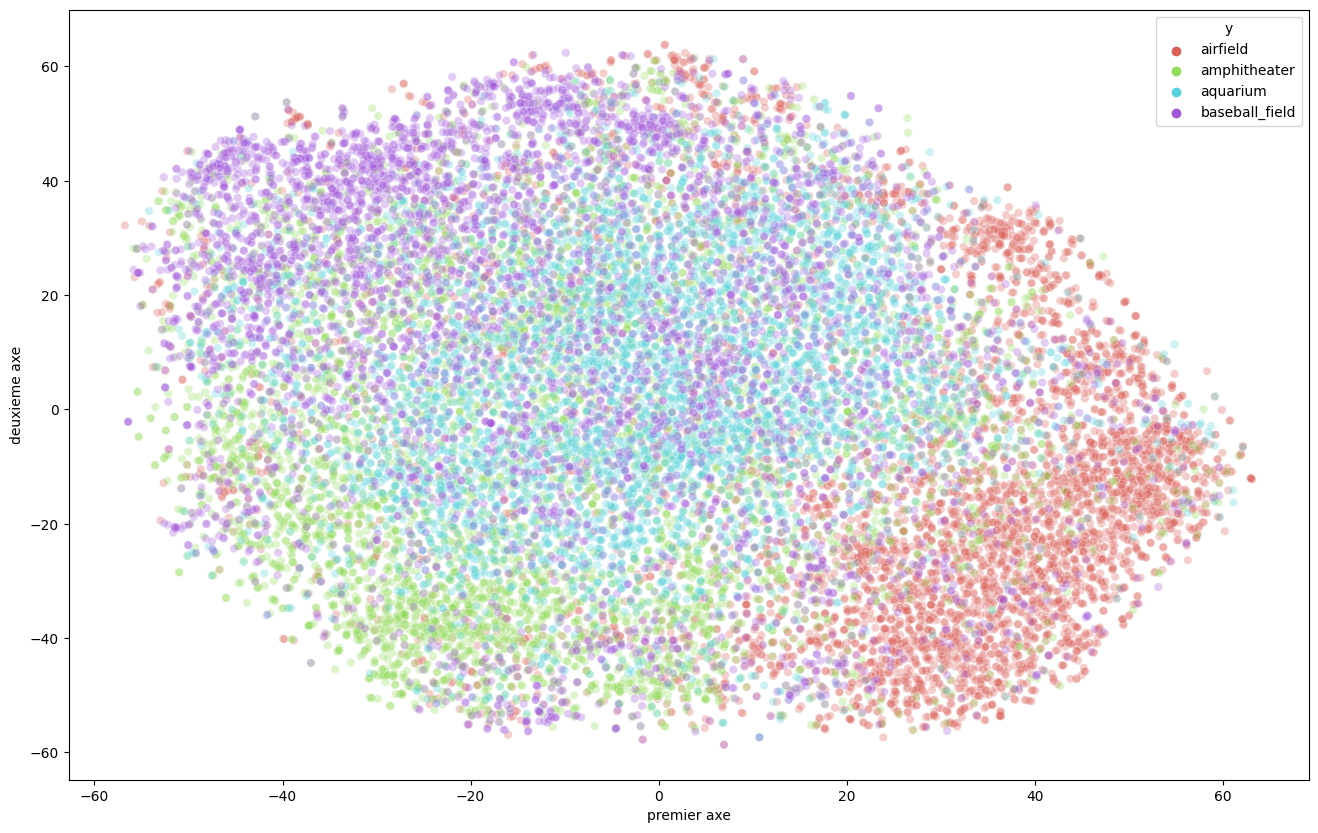

In [14]:
plot(places_y_simclr,places.labels_list,places_classes)

In [13]:
e_weather = extractor(model,weather,device)
weather_y = project(e_weather)

Computing embeddings.


100%|██████████| 6688/6688 [01:50<00:00, 60.33it/s]


Computing PCA and TSNE


C:\Users\ilias\anaconda3\envs\tpenv\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\ilias\anaconda3\envs\tpenv\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 6688 samples in 0.000s...
[t-SNE] Computed neighbors for 6688 samples in 0.212s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6688
[t-SNE] Computed conditional probabilities for sample 2000 / 6688
[t-SNE] Computed conditional probabilities for sample 3000 / 6688
[t-SNE] Computed conditional probabilities for sample 4000 / 6688
[t-SNE] Computed conditional probabilities for sample 5000 / 6688
[t-SNE] Computed conditional probabilities for sample 6000 / 6688
[t-SNE] Computed conditional probabilities for sample 6688 / 6688
[t-SNE] Mean sigma: 12.247266
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.415924
[t-SNE] KL divergence after 1000 iterations: 2.087316


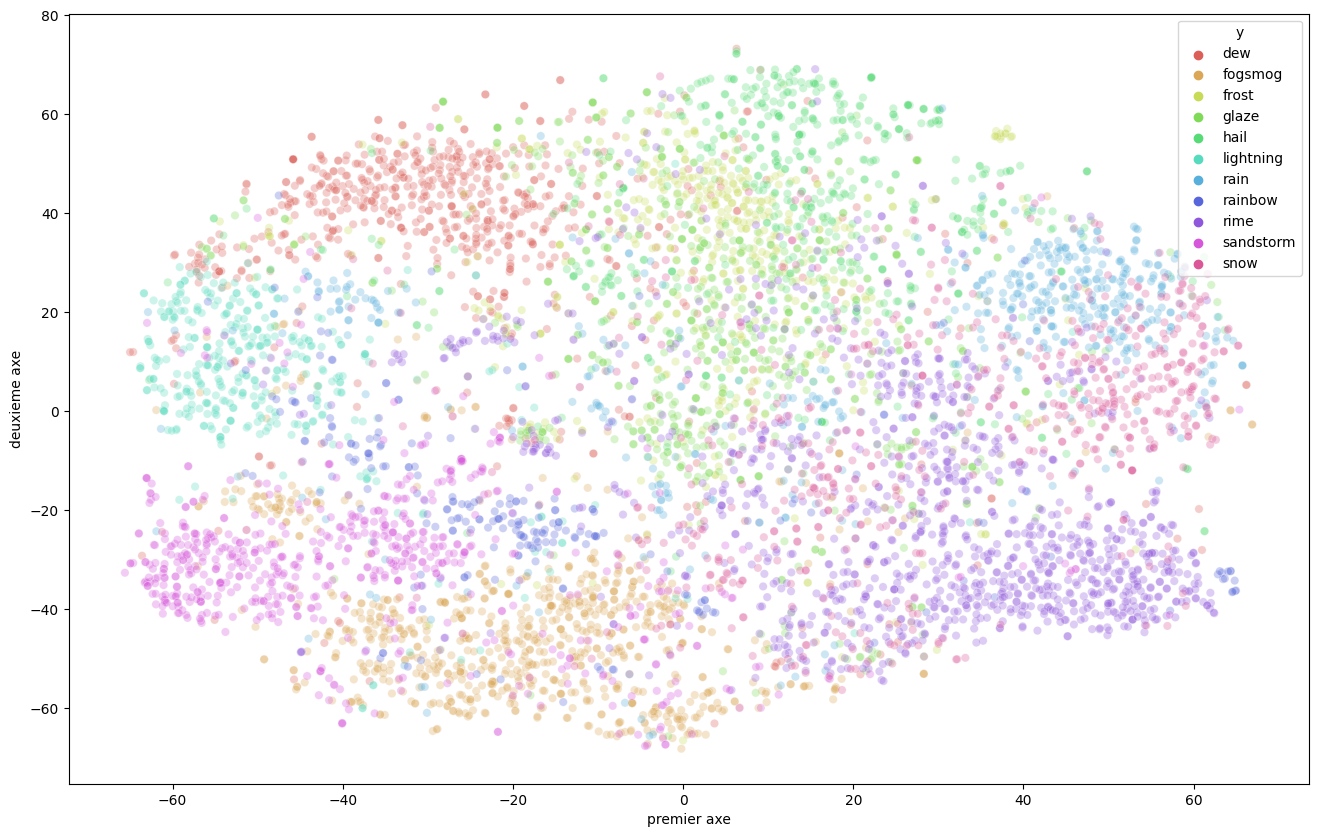

In [15]:
plot(weather_y,weather.labels_list,weather_classes)

In [17]:
model_simclr = load_simclr().to(device)
e_weather_simclr = extractor(model_simclr,weather,device)
weather_y_simclr = project(e_weather_simclr,model_type='simclr')

Model loaded.
Computing embeddings.


100%|██████████| 6688/6688 [01:12<00:00, 92.47it/s] 


Computing PCA and TSNE


C:\Users\ilias\anaconda3\envs\tpenv\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\ilias\anaconda3\envs\tpenv\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 6688 samples in 0.002s...
[t-SNE] Computed neighbors for 6688 samples in 0.260s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6688
[t-SNE] Computed conditional probabilities for sample 2000 / 6688
[t-SNE] Computed conditional probabilities for sample 3000 / 6688
[t-SNE] Computed conditional probabilities for sample 4000 / 6688
[t-SNE] Computed conditional probabilities for sample 5000 / 6688
[t-SNE] Computed conditional probabilities for sample 6000 / 6688
[t-SNE] Computed conditional probabilities for sample 6688 / 6688
[t-SNE] Mean sigma: 0.262453
[t-SNE] KL divergence after 100 iterations with early exaggeration: 88.072929
[t-SNE] KL divergence after 1000 iterations: 2.939254


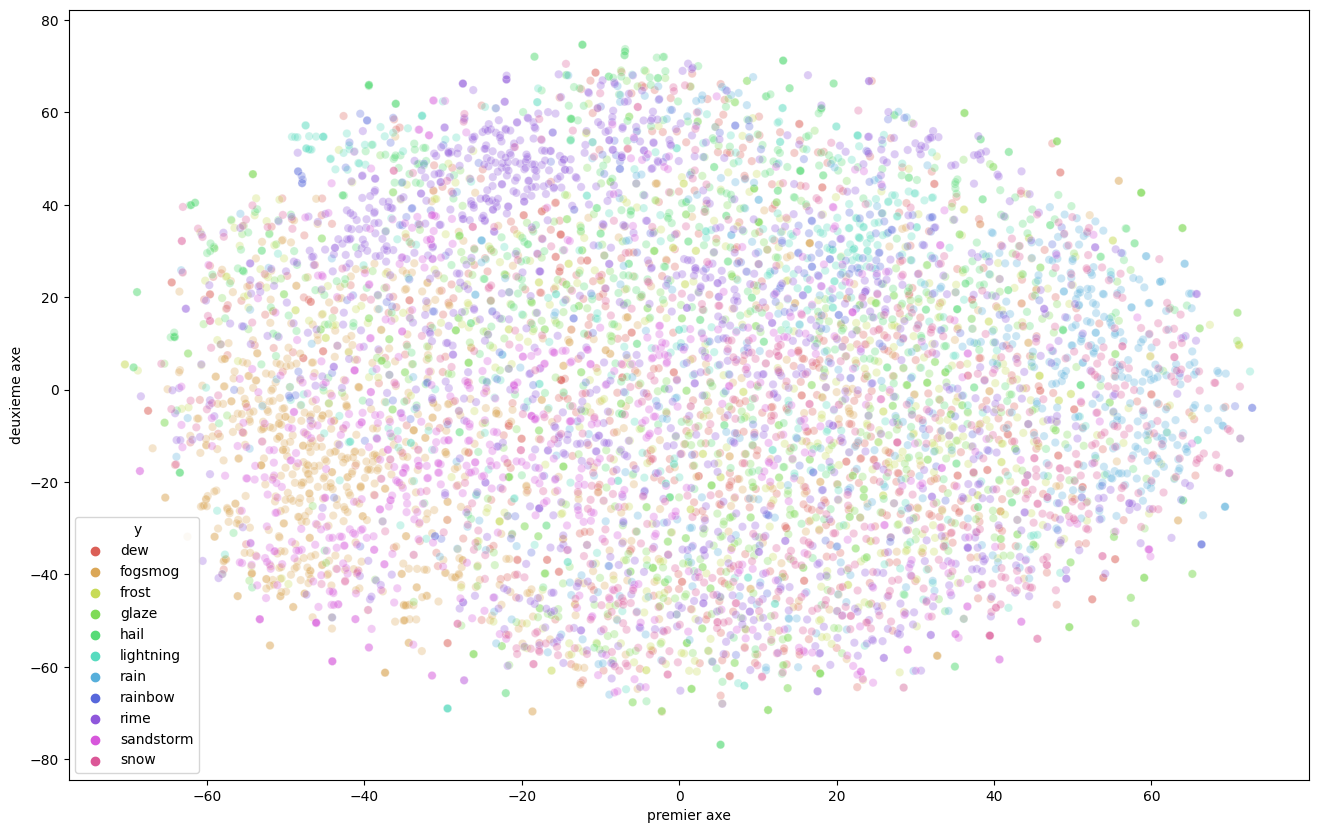

In [18]:
plot(weather_y_simclr,weather.labels_list,weather_classes)

In [21]:
knn(torch.tensor(weather_y),weather.labels_list,k=20)

100%|██████████| 6688/6688 [00:08<00:00, 822.45it/s]


0.5551734449760766

In [22]:
knn(torch.tensor(weather_y_simclr),weather.labels_list,k=20)

100%|██████████| 6688/6688 [00:08<00:00, 806.55it/s]


0.2631578947368421

In [24]:
knn(torch.tensor(places_y),places.labels_list,k=20)

100%|██████████| 20000/20000 [00:54<00:00, 365.86it/s]


0.7009

In [25]:
knn(torch.tensor(places_y_simclr),places.labels_list,k=20)

100%|██████████| 20000/20000 [00:54<00:00, 364.00it/s]


0.49465

## KL divergence is better with MAE, maybe due to student distribution being a good tool to modelize MAE features. However, we should investigate if this is good argumentation since PCA modifies it. KNN performances are also better with MAE.